In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
#from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import norm
from openml import tasks, flows, runs, datasets, config
import random
from sklearn.pipeline import Pipeline
import os

img_location = "./dataset/images"
cropped_image_loc = "./dataset/cropped_images"

olps = os.listdir(img_location)
olps

['bajrang_punia',
 'lovlina_borgohain',
 'mirabai_chanu',
 'neeraj_chopra',
 'pr_sreejesh',
 'pv_sindhu',
 'ravi_kumar_dahiya']

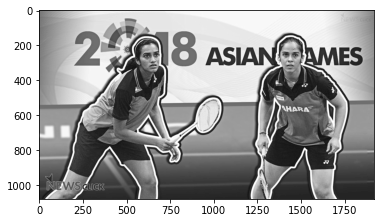

In [2]:
img = cv2.imread("./dataset/test_images/pv_sindhu.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

In [3]:
face_cascade = cv2.CascadeClassifier('./openCV/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./openCV/haarcascades/haarcascade_eye.xml')

In [4]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[1361,  195,  156,  156],
       [ 561,  194,  166,  166]], dtype=int32)

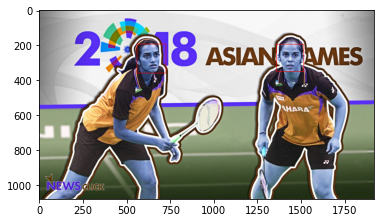

In [5]:
for x,y,w,h in faces:
    img = cv2.rectangle(img,(x,y), (x+w,y+h), (250,0,0),2)

plt.imshow(img)

In [6]:
eyes = eye_cascade.detectMultiScale(img)
eyes

array([[1418,  283,   23,   23],
       [1439,  282,   24,   24],
       [ 488,  231,   23,   23],
       [ 652,  238,   38,   38],
       [1393,  237,   38,   38],
       [1449,  239,   38,   38],
       [ 598,  244,   38,   38],
       [ 168, 1008,   30,   30]], dtype=int32)

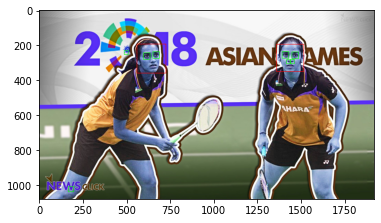

In [7]:
for x,y,w,h in eyes:
    img = cv2.rectangle(img,(x,y), (x+w,y+h),(0,255,0),2)

plt.imshow(img)

In [8]:
def cropImage(img_loc):
    lst = []
    img = cv2.imread(img_loc)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)

        if(len(eyes)>=2):
          lst.append(roi_color)

    return lst

In [9]:
lst = cropImage("./dataset/test_images/pv_sindhu.jpg")

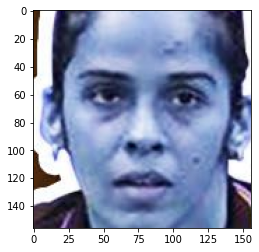

In [10]:
plt.imshow(lst[0])

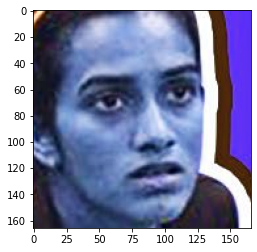

In [11]:
plt.imshow(lst[1])

In [12]:
import shutil

if(os.path.exists(cropped_image_loc)):
    shutil.rmtree(cropped_image_loc)

os.mkdir(cropped_image_loc)

for olp in olps:
    if not os.path.exists(cropped_image_loc+"/"+olp):
        os.mkdir(cropped_image_loc+"/"+olp)

In [13]:
X = []
y = []

In [14]:
for olp in olps:
    print("-------started writing fot {}".format(olp))
    img_folder = img_location + "/" + olp
    cropped_saving_folder = cropped_image_loc + "/" + olp
    cnt = 1

    for img in os.listdir(img_folder):
        img_loc = img_folder + "/" + img
        try:
            for img in cropImage(img_loc):
                cv2.imwrite(cropped_saving_folder+"/"+olp+str(cnt)+".png", img)
                cnt += 1
        except:
            pass
    print("-------done writing fot {}".format(olp))

-------started writing fot bajrang_punia
-------done writing fot bajrang_punia
-------started writing fot lovlina_borgohain
-------done writing fot lovlina_borgohain
-------started writing fot mirabai_chanu
-------done writing fot mirabai_chanu
-------started writing fot neeraj_chopra
-------done writing fot neeraj_chopra
-------started writing fot pr_sreejesh
-------done writing fot pr_sreejesh
-------started writing fot pv_sindhu
-------done writing fot pv_sindhu
-------started writing fot ravi_kumar_dahiya
-------done writing fot ravi_kumar_dahiya


In [15]:
olp_img = {}
olp_index = {}

for index,olp in enumerate(olps):
    olp_index[olp] = index
    cropped_saving_folder = cropped_image_loc + "/" + olp
    olp_img[olp] = []

    for img in os.listdir(cropped_saving_folder):
        olp_img[olp].append(cropped_saving_folder+"/"+img)

olp_index

{'bajrang_punia': 0,
 'lovlina_borgohain': 1,
 'mirabai_chanu': 2,
 'neeraj_chopra': 3,
 'pr_sreejesh': 4,
 'pv_sindhu': 5,
 'ravi_kumar_dahiya': 6}

In [16]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

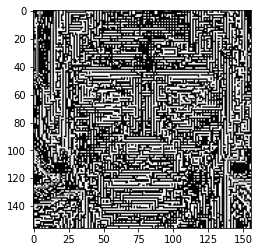

In [17]:
plt.imshow(w2d(cropImage("./dataset/test_images/pv_sindhu.jpg")[0]), cmap="gray")

In [18]:
for olp, img_folder in olp_img.items():
    for img in img_folder:
        img = cv2.imread(img)
        img = cv2.resize(img, (32,32))
        img_wt = w2d(img)
        img_wt = cv2.resize(img_wt, (32,32))
        combined_img = np.vstack((img.reshape(32*32*3,1), img_wt.reshape(32*32,1)))
        X.append(combined_img)
        y.append(olp_index[olp])

In [19]:
X = np.array(X).reshape(len(X), 32*32*4).astype(float)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
pipeline = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svc", svm.SVC()),
])

In [22]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.6451612903225806

In [23]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
                'n_estimators': randint(10,100),
                "max_features": randint(1,64),
                'max_depth': [randint(5,50), None],
                "min_samples_split": randint(2,11),
                "min_samples_leaf": randint(1,11),
                "criterion":['gini','entropy'],
                "bootstrap": [True, False],
        }
    },
    'svm': {
        'model': svm.SVC(gamma='auto', C=0.1),
        'params': {
            # 'C': [0.1,1, 10, 100],
            'kernel': ['rbf', 'poly', 'sigmoid'],
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
            'max_iter' : [100, 1000,2500, 5000],

        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            "max_depth": [2, 3, 4, 5, 6, 7, 8 , 9, None],
            "max_features": [2, 3, 4, 5, 6, 7, 8 , 9],
            "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8 , 9, None],
            "criterion": ["gini", "entropy"],
            "splitter": ["best", "random"]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
        }
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {
            'alpha':np.linspace(0.1,1,10)
        }
    },
}

score = []
best_estimators = {}

for model_name, mp in model_params.items():
    clf =  RandomizedSearchCV(mp['model'], mp['params'], n_iter=5, cv=3,scoring='accuracy')
    clf.fit(X, y)
    score.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[model_name] = clf.best_estimator_
    
df = pd.DataFrame(score,columns=['model','best_score','best_params'])
df


D:\program files\python\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\program files\python\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\program files\python\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "D:\program files\python\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\program files\python\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\program files\python\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  Fil

,model,best_score,best_params
0,random_forest,0.524390,"{'bootstrap': False, 'criterion': 'entropy', '..."
1,svm,0.476190,{'kernel': 'poly'}
2,logistic_regression,0.580720,"{'solver': 'sag', 'penalty': 'l2', 'max_iter':..."
3,decision_tree,0.370499,"{'splitter': 'random', 'min_samples_leaf': 6, ..."
4,GaussianNB,0.427410,{'var_smoothing': 1e-08}
5,MultinomialNB,0.556330,{'alpha': 10.0}
6,BernoulliNB,0.281843,{'alpha': 0.30000000000000004}


In [25]:
best_estimators["logistic_regression"].score(X, y)

1.0

In [26]:
joblib.dump(best_estimators["logistic_regression"], "model.pkl")

['olympians_recognizer.pkl']

In [27]:
import json
with open("name.json", "w") as f:
    f.write(json.dumps(olp_index))